# Data understanding II and cleaning
**Part 2**

The purpose of this project is to predict the price of housing in different block groups accross California based on a set of input attributes within the dataset. Each row represents the data of an observed block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression

In [2]:
housing = pd.read_csv('data/housing.csv')

  ## Exploring the relationships between variables

In [3]:
housing.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


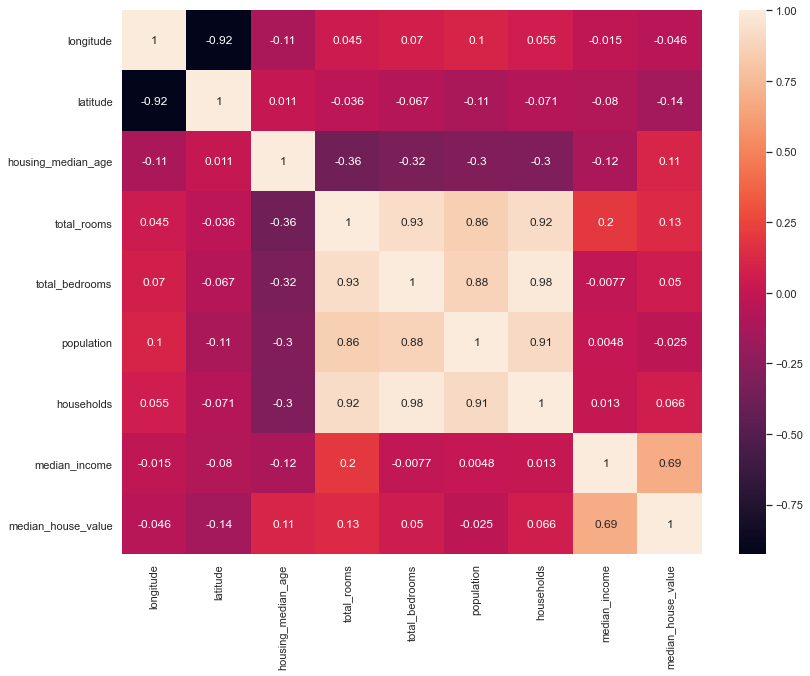

In [4]:
corr = housing.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

In [4]:
# Exclucde latitude and longitude
corr_columns = ['housing_median_age', 'total_rooms','total_bedrooms', 
                'population', 'households','median_income','median_house_value', 'ocean_proximity']
corr_df = housing[corr_columns].dropna(axis=0)

# encoding based on central tendency to analyse if ocean_proximity has any correlation with mean_house_value
corr_df['ocean_proximity'] = corr_df['ocean_proximity'].replace({'INLAND':0,'<1H OCEAN':1,'NEAR OCEAN':2,'NEAR BAY':3,'ISLAND':4})

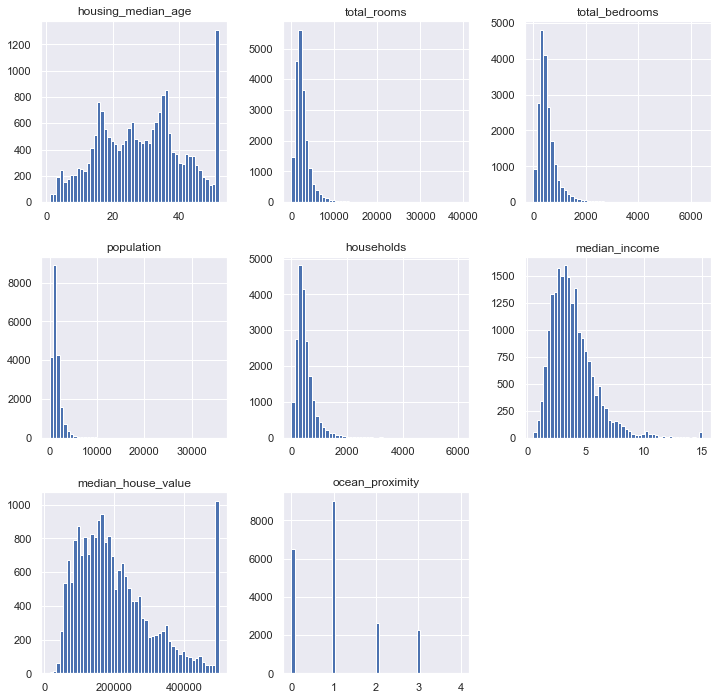

In [5]:
corr_df.hist(bins=50, figsize=(12, 12))
plt.show()

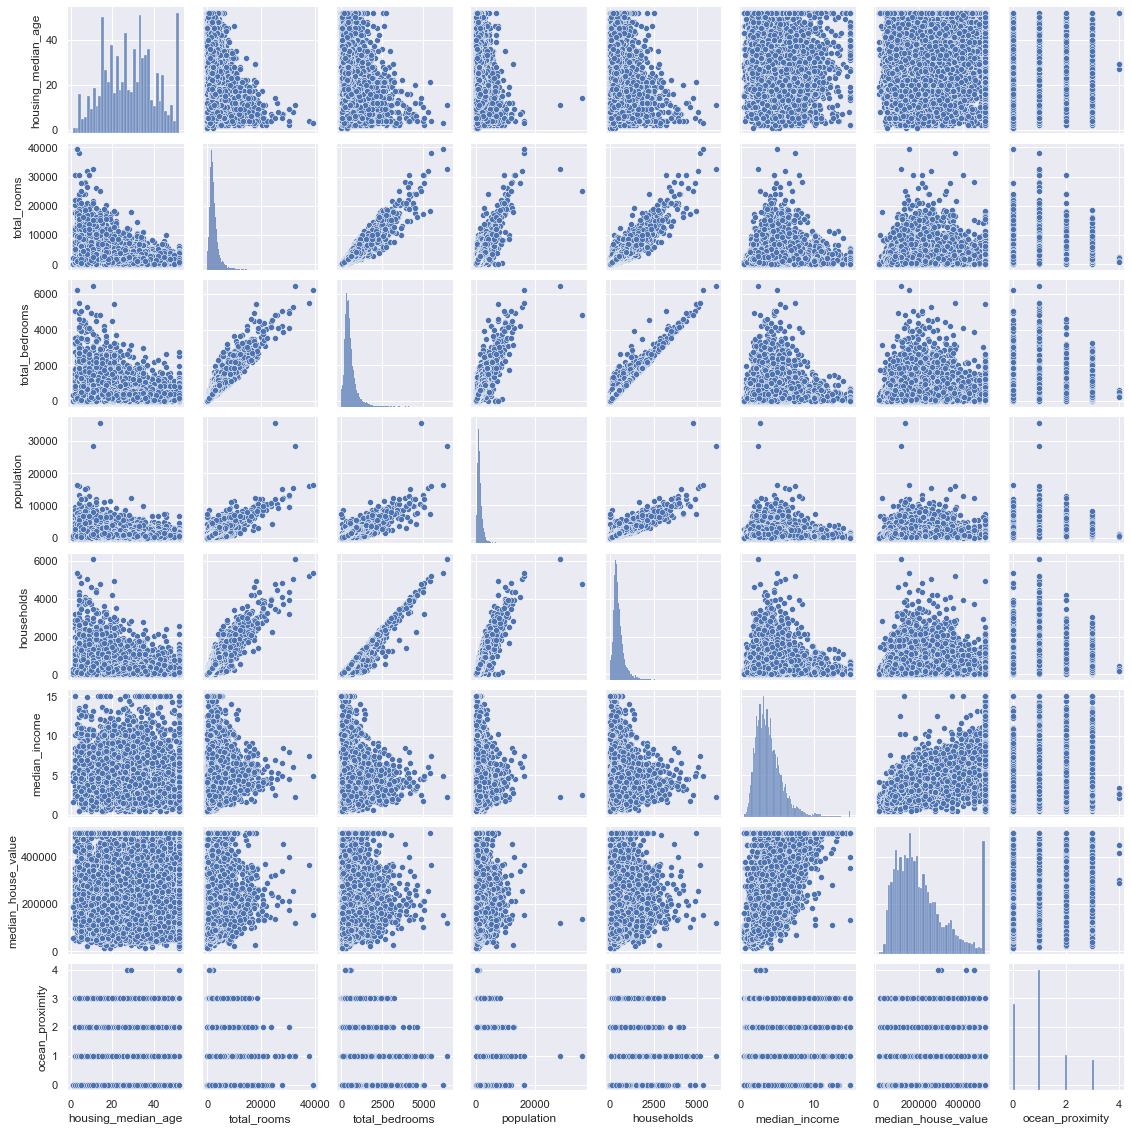

In [6]:
sns.pairplot(corr_df, height = 2, dropna=True)
plt.show()

## Filling in missing values with linear regression
Due to the strong relationship between the variables mentioned above. I can use linear regression to fill in the rows with missing bedroom values, which is preferable to removing them. However the predictor variables themselves are strongly correlated with each other which violates the OLS assumptions. 

I will compare a model (model 2) with 1 single best variable and another model (model 1) all 3 of them.

                            OLS Regression Results                            
Dep. Variable:         total_bedrooms   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 2.000e+05
Date:                Wed, 28 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:40:07   Log-Likelihood:            -1.1761e+05
No. Observations:               20433   AIC:                         2.352e+05
Df Residuals:                   20429   BIC:                         2.353e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7599      0.885      0.859      

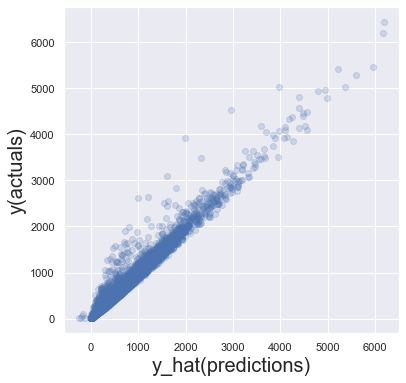

In [7]:
x1 = housing[housing['total_bedrooms'].notna()][['total_rooms','population','households']]
y = housing[housing['total_bedrooms'].notna()]['total_bedrooms']
x = sm.add_constant(x1)
model1 = sm.OLS(y,x).fit()
print(model1.summary())

plt.rcParams['figure.figsize']=(6, 6) 
y_hat = model1.predict(x)
plt.scatter(y_hat, y, alpha=0.2)
plt.xlabel('y_hat(predictions)', fontsize = 20)
plt.ylabel('y(actuals)', fontsize = 20)
plt.show()

                            OLS Regression Results                            
Dep. Variable:         total_bedrooms   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 4.887e+05
Date:                Wed, 28 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:40:08   Log-Likelihood:            -1.1963e+05
No. Observations:               20433   AIC:                         2.393e+05
Df Residuals:                   20431   BIC:                         2.393e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4649      0.972     -1.508      0.1

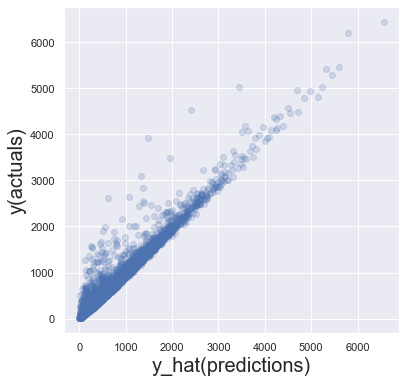

In [8]:
x1 = housing[housing['total_bedrooms'].notna()][['households']]
y = housing[housing['total_bedrooms'].notna()]['total_bedrooms']
x = sm.add_constant(x1)
model2 = sm.OLS(y,x).fit()
print(model2.summary())

plt.rcParams['figure.figsize']=(6, 6) 
y_hat2 = model2.predict(x)
plt.scatter(y_hat2, y, alpha=0.2)
plt.xlabel('y_hat(predictions)', fontsize = 20)
plt.ylabel('y(actuals)', fontsize = 20)
plt.show()

Model 1 has the higher r-squared value but lower F-statistic value meaning it is less significant - no doubt because the variables are correlated. I will use model 2 because all 3 variables in model 1 are correlated which breaks the OLS assumptions for a good model

In [9]:
housing_filled = housing.copy()

missing_totalbedrooms = housing[housing['total_bedrooms'].isna()]
missing_totalbedrooms_x1 = missing_totalbedrooms[['households']]
missing_totalbedrooms_x = sm.add_constant(missing_totalbedrooms_x1)
missing_totalbedrooms_y_hat = model2.predict(missing_totalbedrooms_x)

housing_filled.loc[housing_filled['total_bedrooms'].isna(), 'total_bedrooms'] = missing_totalbedrooms_y_hat

In [10]:
housing_filled.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [11]:
housing_filled.shape

(20640, 10)

## Fixing noise points - median_house_value
## Analysing city features
Determining whether outlier (extremely expensive) housing blocks are correlated with an inside_city feature 

![California map](images/google_map.PNG)

In [12]:
"""
Lambda and function transformation for multiple columns with round. Not necessary

def coord_dist(df, city):
    ecd = np.sqrt((df.latitude-37.7749)**2 + (df.longitude+122.4149)**2)
    return np.round(ecd, 4)

housing['sf_dist'] = housing.apply(lambda x :coord_dist(x[['latitude','longitude']], sf), axis=1)
"""

# Creating a distance to city variable

housing_filled['sf_dist'] = np.round(np.sqrt((housing['latitude']-37.7749)**2 + (housing['longitude']+122.4149)**2), 4)
housing_filled['la_dist'] = np.round(np.sqrt((housing['latitude']-34.0522)**2 + (housing['longitude']+118.2437)**2), 4)
housing_filled['sd_dist'] = np.round(np.sqrt((housing['latitude']-32.7157)**2 + (housing['longitude']+117.1611)**2), 4)

In [13]:
def in_city(df):
    if (df.sf_dist<=1) or (df.la_dist<=1) or (df.sd_dist<=.5):
        return 1
    else:
        return 0

housing_filled['in_city'] = housing_filled.apply(in_city, axis=1)

In [14]:
housing_filled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,sf_dist,la_dist,sd_dist,in_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.2127,5.5265,7.2363,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.2127,5.5055,7.2150,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.1903,5.5130,7.2219,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.1812,5.5203,7.2290,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.1812,5.5203,7.2290,1


In [15]:
housing_filled.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.924664,-0.108197,0.044568,0.068300,0.099773,0.055310,-0.015176,-0.045967,0.963448,-0.897376,-0.965216,0.208997
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066306,-0.108785,-0.071035,-0.079809,-0.144160,-0.899136,0.936204,0.986774,-0.428518
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320433,-0.296244,-0.302916,-0.119034,0.105623,-0.105806,-0.026221,0.043284,0.235396
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.929819,0.857126,0.918484,0.198050,0.134153,0.034173,-0.017528,-0.039341,0.006704
total_bedrooms,0.068300,-0.066306,-0.320433,0.929819,1.000000,0.878066,0.979929,-0.007900,0.050762,0.060897,-0.053565,-0.067484,0.025744
population,0.099773,-0.108785,-0.296244,0.857126,0.878066,1.000000,0.907222,0.004834,-0.024650,0.089353,-0.108402,-0.109448,0.062559
households,0.055310,-0.071035,-0.302916,0.918484,0.979929,0.907222,1.000000,0.013033,0.065843,0.049610,-0.059573,-0.068023,0.062608
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007900,0.004834,0.013033,1.000000,0.688075,-0.026196,-0.057687,-0.048121,0.269260
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.050762,-0.024650,0.065843,0.688075,1.000000,-0.040823,-0.116874,-0.077845,0.437260
sf_dist,0.963448,-0.899136,-0.105806,0.034173,0.060897,0.089353,0.049610,-0.026196,-0.040823,1.000000,-0.858577,-0.937012,0.210005


## Fixing outliers

housing_outrem will the temporary dataframe to compare the effect of removing data. At the end of the data cleaning exploration, the selected cleaning procedures will be performed on the housing_filled dataframe before being exported

## Fixing outliers - Housing median age

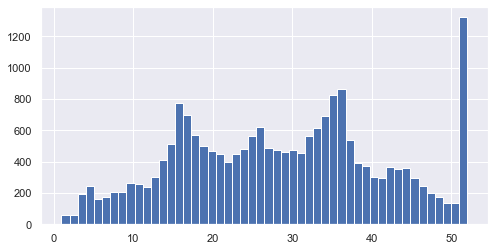

In [16]:
plt.rcParams['figure.figsize']=(8, 4)
housing_filled['housing_median_age'].hist(bins=50)
plt.show()

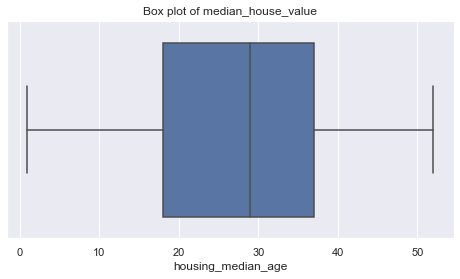

In [17]:
sns.boxplot(x=housing_filled['housing_median_age']).set_title('Box plot of median_house_value')
plt.show()

In [18]:
housing_age_max = housing_filled['housing_median_age'].max()
print(f'The Maximum housing age: {housing_age_max}')

housing_age_95 = housing_filled['housing_median_age'].quantile(.95)
print(f'The 95th percentile housing age: {housing_age_95}')

number = housing_filled[housing_filled['housing_median_age']==housing_age_max].shape[0]
print(f'Number of observations at max {number}')
print('Percent of observations at max %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_filled[housing_filled['housing_median_age']>=housing_age_95].shape[0]
print(f'Number of observations greather than 95th percentile {number}')
print('Percent of observations greater 95th percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum housing age: 52.0
The 95th percentile housing age: 52.0
Number of observations at max 1273
Percent of observations at max 6.168%
Number of observations greather than 95th percentile 1273
Percent of observations greater 95th percentile 6.168%


In [19]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['housing_median_age'] < housing_age_max]
housing_outrem.shape

(19367, 14)

In [20]:
housing_outrem.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.922948,-0.033388,0.035774,0.064762,0.088660,0.051257,-0.020090,-0.015860,0.962027,-0.891371,-0.963434,0.237380
latitude,-0.922948,1.000000,-0.052193,-0.030126,-0.064323,-0.101946,-0.069372,-0.079075,-0.173318,-0.898335,0.934101,0.986775,-0.452836
housing_median_age,-0.033388,-0.052193,1.000000,-0.365075,-0.324621,-0.280303,-0.304711,-0.143356,0.039988,-0.026098,-0.104631,-0.027792,0.223896
total_rooms,0.035774,-0.030126,-0.365075,1.000000,0.931366,0.857890,0.919629,0.202871,0.146048,0.024424,-0.009972,-0.032205,0.012328
total_bedrooms,0.064762,-0.064323,-0.324621,0.931366,1.000000,0.879543,0.979584,-0.002779,0.058366,0.056840,-0.051289,-0.065064,0.030649
population,0.088660,-0.101946,-0.280303,0.857890,0.879543,1.000000,0.909265,0.008626,-0.011199,0.077334,-0.100993,-0.101115,0.071866
households,0.051257,-0.069372,-0.304711,0.919629,0.979584,0.909265,1.000000,0.018552,0.073829,0.045184,-0.057758,-0.065798,0.068307
median_income,-0.020090,-0.079075,-0.143356,0.202871,-0.002779,0.008626,0.018552,1.000000,0.704284,-0.031121,-0.054547,-0.046515,0.275768
median_house_value,-0.015860,-0.173318,0.039988,0.146048,0.058366,-0.011199,0.073829,0.704284,1.000000,-0.006443,-0.149445,-0.110033,0.435332
sf_dist,0.962027,-0.898335,-0.026098,0.024424,0.056840,0.077334,0.045184,-0.031121,-0.006443,1.000000,-0.851811,-0.935318,0.243409


## Fixing outliers - Median income 

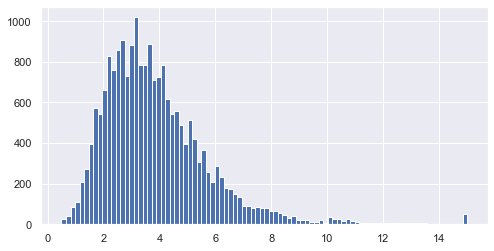

In [21]:
housing_filled['median_income'].hist(bins=90)
plt.show()

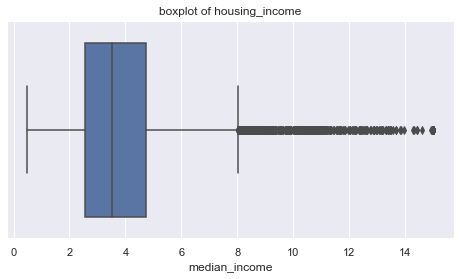

In [22]:
sns.boxplot(x=housing_filled['median_income']).set_title('boxplot of housing_income')
plt.show()

In [23]:
income_max = housing_filled['median_income'].max()
print(f'The Maximum housing income: {income_max}')

income_95 = housing_filled['median_income'].quantile(.95)
print(f'The 95th percentile housing income: {income_95}')

number = housing_filled[housing_filled['median_income']==income_max].shape[0]
print(f'Number of observations at max: {number}')
print('Percent of observations at max: %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_filled[housing_filled['median_income']>=income_95].shape[0]
print(f'Number of observations greater than 95th percentile {number}')
print('Percent of observations greater than 95th percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum housing income: 15.0001
The 95th percentile housing income: 7.300305
Number of observations at max: 49
Percent of observations at max: 0.237%
Number of observations greater than 95th percentile 1032
Percent of observations greater than 95th percentile 5.000%


In [24]:
number = housing_filled[housing_filled['median_income']>=10].shape[0]
print(f'Number of observations greater than 10 {number}')
print('Percent of observations greater than 10 %.3f' % (number/housing.shape[0]*100)+'%')

Number of observations greater than 10 309
Percent of observations greater than 10 1.497%


In [25]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] < 10]
housing_outrem.shape

(20331, 14)

In [26]:
housing_outrem.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.924351,-0.108257,0.042750,0.066692,0.099371,0.053764,-0.012950,-0.046153,0.962921,-0.896759,-0.964948,0.211802
latitude,-0.924351,1.000000,0.010360,-0.033857,-0.065947,-0.109536,-0.070799,-0.083701,-0.145894,-0.898494,0.935958,0.986755,-0.430881
housing_median_age,-0.108257,0.010360,1.000000,-0.363004,-0.321313,-0.297257,-0.303851,-0.151629,0.109070,-0.105936,-0.026348,0.042679,0.237391
total_rooms,0.042750,-0.033857,-0.363004,1.000000,0.931935,0.859270,0.920386,0.226264,0.134190,0.032059,-0.014787,-0.037171,0.004845
total_bedrooms,0.066692,-0.065947,-0.321313,0.931935,1.000000,0.878320,0.979900,0.020628,0.066440,0.059078,-0.052872,-0.066661,0.028713
population,0.099371,-0.109536,-0.297257,0.859270,0.878320,1.000000,0.907579,0.031798,-0.014157,0.088777,-0.108987,-0.109807,0.065086
households,0.053764,-0.070799,-0.303851,0.920386,0.979900,0.907579,1.000000,0.044473,0.081723,0.047840,-0.058914,-0.067302,0.065523
median_income,-0.012950,-0.083701,-0.151629,0.226264,0.020628,0.031798,0.044473,1.000000,0.661432,-0.025623,-0.057969,-0.051771,0.276751
median_house_value,-0.046153,-0.145894,0.109070,0.134190,0.066440,-0.014157,0.081723,0.661432,1.000000,-0.040716,-0.118019,-0.079043,0.437557
sf_dist,0.962921,-0.898494,-0.105936,0.032059,0.059078,0.088777,0.047840,-0.025623,-0.040716,1.000000,-0.857287,-0.936325,0.213002


In [27]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] <= 14]
print(housing_outrem.shape)
housing_outrem.corr().style.background_gradient()

(20583, 14)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.924620,-0.108736,0.044090,0.068090,0.099549,0.055044,-0.016016,-0.046698,0.963363,-0.897286,-0.965174,0.209154
latitude,-0.924620,1.000000,0.011827,-0.035754,-0.066491,-0.108962,-0.071206,-0.080128,-0.143770,-0.899042,0.936162,0.986773,-0.428670
housing_median_age,-0.108736,0.011827,1.000000,-0.361629,-0.319810,-0.295655,-0.302245,-0.138834,0.101289,-0.106361,-0.025180,0.043911,0.234877
total_rooms,0.044090,-0.035754,-0.361629,1.000000,0.930074,0.857262,0.918716,0.211624,0.136542,0.033620,-0.017143,-0.038931,0.006979
total_bedrooms,0.068090,-0.066491,-0.319810,0.930074,1.000000,0.877894,0.979900,0.002717,0.055541,0.060647,-0.053873,-0.067532,0.026778
population,0.099549,-0.108962,-0.295655,0.857262,0.877894,1.000000,0.907090,0.015443,-0.020863,0.089089,-0.108735,-0.109491,0.063525
households,0.055044,-0.071206,-0.302245,0.918716,0.979900,0.907090,1.000000,0.024707,0.070747,0.049305,-0.059866,-0.068043,0.063661
median_income,-0.016016,-0.080128,-0.138834,0.211624,0.002717,0.015443,0.024707,1.000000,0.687380,-0.027676,-0.055416,-0.048046,0.273479
median_house_value,-0.046698,-0.143770,0.101289,0.136542,0.055541,-0.020863,0.070747,0.687380,1.000000,-0.041571,-0.115648,-0.077315,0.437170
sf_dist,0.963363,-0.899042,-0.106361,0.033620,0.060647,0.089089,0.049305,-0.027676,-0.041571,1.000000,-0.858360,-0.936905,0.210189


## Fixing outliers - Median house value

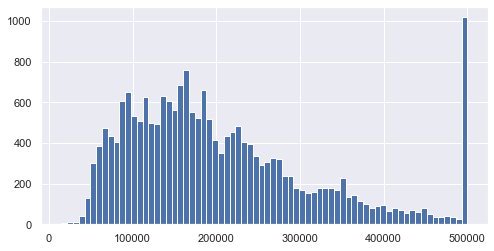

In [28]:
housing_filled['median_house_value'].hist(bins=70)
plt.show()

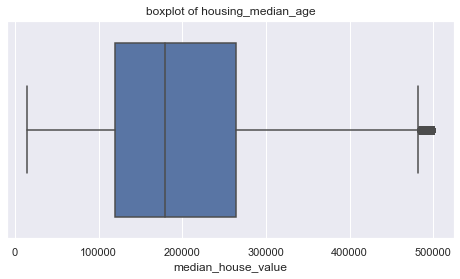

In [29]:
sns.boxplot(x=housing_filled['median_house_value']).set_title('boxplot of housing_median_age')
plt.show()

In [30]:
value_max = housing_filled['median_house_value'].max()
print(f'The Maximum house value= {value_max}')

value_95 = housing_filled['median_house_value'].quantile(.95)
print(f'The 95th percentile house value = {value_95}')

number = housing_filled[housing_filled['median_house_value']==value_max].shape[0]
print(f'Number of observations at max {number}')
print('Percent of observations at max %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_filled[housing_filled['median_house_value']>=value_95].shape[0]
print(f'Number of observations greather than 95th percentile {number}')
print('Percent of observations greather than percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum house value= 500001.0
The 95th percentile house value = 489809.9999999998
Number of observations at max 965
Percent of observations at max 4.675%
Number of observations greather than 95th percentile 1032
Percent of observations greather than percentile 5.000%


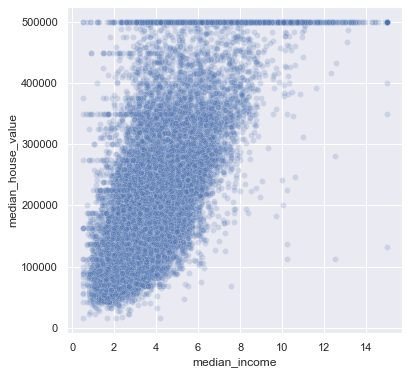

In [31]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=housing_filled['median_income'], y=housing_filled['median_house_value'], alpha=0.2)
plt.show()

An unusual number of houses at the max value (4.675%)
Possibly a neighbourhood of similar luxury housing block estates managed by the same real estate developer. We will treat this as an outlier for now and take this out of the dataset.

First I have to take out the income outliers from housing_filled again, adnt then take out the outliers for median house value

In [32]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] < 10]
housing_outrem = housing_outrem[housing_outrem['median_house_value'] < value_max]
housing_outrem.shape

(19626, 14)

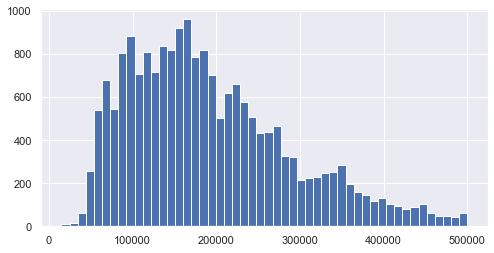

In [33]:
housing_outrem['median_house_value'].hist(bins=50)
plt.show()

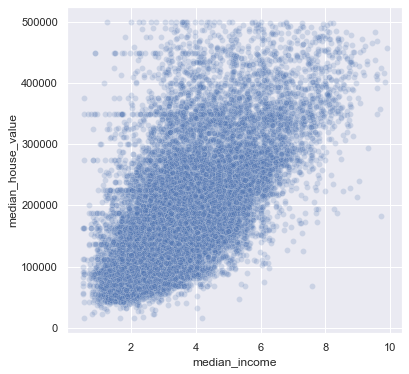

In [34]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=housing_outrem['median_income'], y=housing_outrem['median_house_value'], alpha=0.2)
plt.show()

In [35]:
housing_outrem.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.924067,-0.101675,0.043082,0.068068,0.101024,0.055211,-0.009994,-0.048456,0.961766,-0.895797,-0.964500,0.218705
latitude,-0.924067,1.000000,0.005552,-0.032324,-0.066907,-0.113458,-0.072423,-0.079157,-0.147730,-0.897249,0.935453,0.986777,-0.437432
housing_median_age,-0.101675,0.005552,1.000000,-0.372008,-0.328428,-0.296626,-0.310565,-0.192401,0.074041,-0.098832,-0.032764,0.036716,0.232928
total_rooms,0.043082,-0.032324,-0.372008,1.000000,0.933807,0.860701,0.921491,0.233230,0.143528,0.031724,-0.011668,-0.036266,0.001619
total_bedrooms,0.068068,-0.066907,-0.328428,0.933807,1.000000,0.880459,0.979434,0.029557,0.078329,0.060159,-0.052479,-0.067777,0.028287
population,0.101024,-0.113458,-0.296626,0.860701,0.880459,1.000000,0.909878,0.048883,0.013864,0.090397,-0.112298,-0.113081,0.070981
households,0.055211,-0.072423,-0.310565,0.921491,0.979434,0.909878,1.000000,0.054966,0.097687,0.049074,-0.059136,-0.068965,0.065969
median_income,-0.009994,-0.079157,-0.192401,0.233230,0.029557,0.048883,0.054966,1.000000,0.641985,-0.025358,-0.051036,-0.050405,0.268493
median_house_value,-0.048456,-0.147730,0.074041,0.143528,0.078329,0.013864,0.097687,0.641985,1.000000,-0.044458,-0.116331,-0.080133,0.453042
sf_dist,0.961766,-0.897249,-0.098832,0.031724,0.060159,0.090397,0.049074,-0.025358,-0.044458,1.000000,-0.854456,-0.934799,0.220631


In [36]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] <= 14]
housing_outrem = housing_outrem[housing_outrem['median_house_value'] < value_max]
housing_outrem.shape

(19672, 14)

In [37]:
housing_outrem.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,sf_dist,la_dist,sd_dist,in_city
longitude,1.000000,-0.924137,-0.102578,0.044118,0.068504,0.100870,0.055518,-0.007852,-0.046477,0.961843,-0.895879,-0.964539,0.218581
latitude,-0.924137,1.000000,0.006677,-0.033286,-0.067251,-0.113248,-0.072679,-0.079215,-0.148456,-0.897395,0.935502,0.986787,-0.437235
housing_median_age,-0.102578,0.006677,1.000000,-0.372146,-0.327568,-0.295247,-0.309571,-0.195449,0.068228,-0.099711,-0.031790,0.037806,0.231758
total_rooms,0.044118,-0.033286,-0.372146,1.000000,0.933550,0.859561,0.921086,0.226370,0.143363,0.032846,-0.012564,-0.037260,0.001667
total_bedrooms,0.068504,-0.067251,-0.327568,0.933550,1.000000,0.879498,0.979351,0.023262,0.076074,0.060692,-0.052809,-0.068130,0.027933
population,0.100870,-0.113248,-0.295247,0.859561,0.879498,1.000000,0.908975,0.043894,0.012165,0.090346,-0.112115,-0.112893,0.070995
households,0.055518,-0.072679,-0.309571,0.921086,0.979351,0.908975,1.000000,0.047664,0.095130,0.049501,-0.059449,-0.069242,0.065699
median_income,-0.007852,-0.079215,-0.195449,0.226370,0.023262,0.043894,0.047664,1.000000,0.644152,-0.023336,-0.051311,-0.051252,0.264354
median_house_value,-0.046477,-0.148456,0.068228,0.143363,0.076074,0.012165,0.095130,0.644152,1.000000,-0.042636,-0.116907,-0.081362,0.451629
sf_dist,0.961843,-0.897395,-0.099711,0.032846,0.060692,0.090346,0.049501,-0.023336,-0.042636,1.000000,-0.854643,-0.934916,0.220551


In [38]:
1 - len(housing_outrem)/len(housing_filled)

0.04689922480620157

### Exploring observations at the highest house value

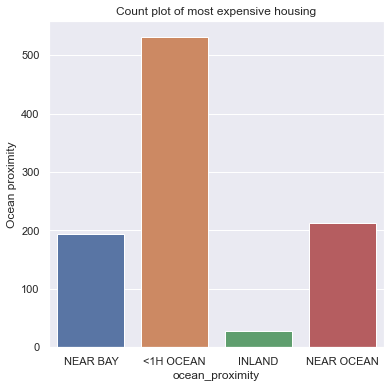

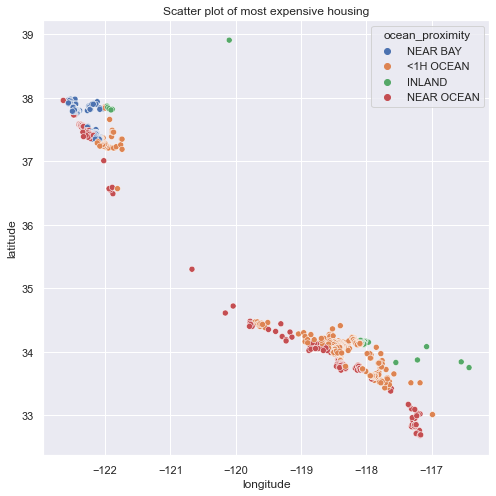

In [39]:
plt.figure(figsize=(6,6))
top_housing = housing[housing['median_house_value']==value_max]
cp = sns.countplot(x='ocean_proximity', data=top_housing)
cp.set_title('Count plot of most expensive housing')
cp.set_ylabel('Ocean proximity')
plt.show()
plt.figure(figsize=(8,8))
sns.scatterplot(data=top_housing, x='longitude', y='latitude', hue='ocean_proximity', legend='full').set_title('Scatter plot of most expensive housing')
plt.show()

## Going back to housing_filled and recleaning with the selected processes
### Then exporting for the next step

In [40]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] <= 10]
housing_outrem.shape

(20332, 14)

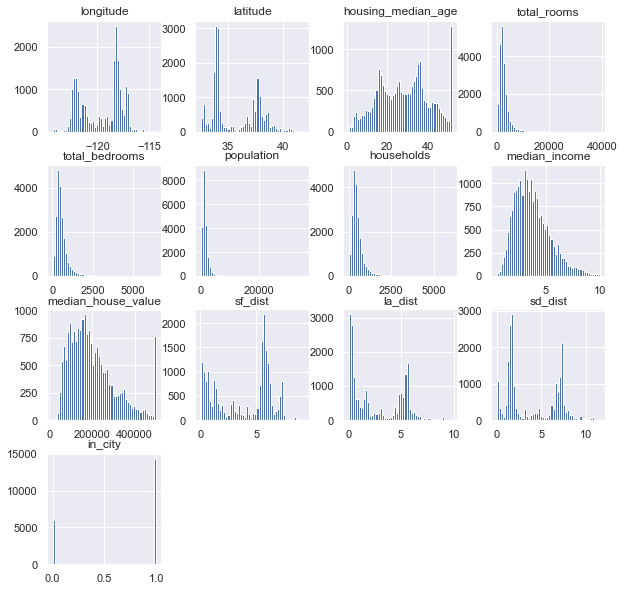

In [41]:
housing_outrem.hist(bins=50, figsize=(10,10))
plt.show()

In [42]:
housing_outrem.shape

(20332, 14)

In [43]:
housing_outrem.to_csv('data/housing_cleaned.csv', index=False)